In [4]:
using Turing
using Random
using Statistics
using Distributions
using StatsPlots
using LaTeXStrings
using DataFrames
using FFTW
using Dierckx
using Zygote

In [5]:
Turing.setadbackend(:zygote)

:zygote

In [6]:
default(xtickfont=font(14),  ytickfont=font(14), guidefont=font(14), 
    legendfontsize=12, lw=2, ms=8)

In [7]:
N = 8;
γ = 0.01;
x = LinRange(0,1,N+1)[2:end-1];

# true value that we wish to recover
# x_data = [0.2, 0.4, 0.6, 0.8];
# n_data = length(x_data);
uᵗ(x) = x*(1-x);

Random.seed!(500); # set a seed for reproducibility
y_data = @. uᵗ(x) + γ * randn()

7-element Vector{Float64}:
 0.10196632248553145
 0.18360272059325755
 0.20890122284291876
 0.2559085030181507
 0.235621878199629
 0.1918683699620499
 0.12004607668251802

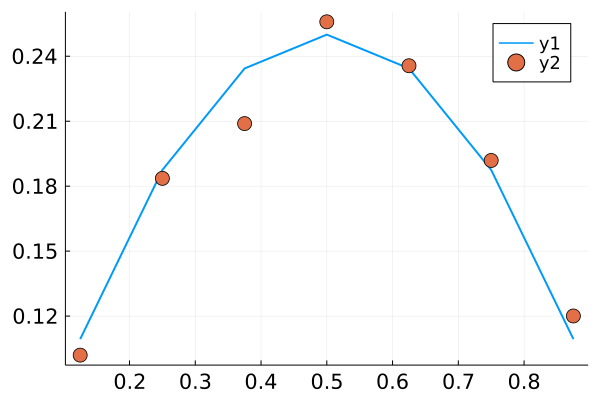

In [8]:
plot(x, uᵗ.(x))
scatter!(x, y_data)

In [9]:
"""
`build_field` - Build a mean zero Gaussian random field with the (-Δ)^{-α} covariance operator in dimension one

### Fields
`ξ`   - Vector of N(0,1) values  
`α=1` - Smoothness parameter
"""
# function build_field(ξ;α=one(eltype(ξ)))
#     N = length(ξ)
    
#     # uhat = zeros(complex(eltype(ξ)),2*N); # preallocate space

#     # construct the eigenvalues
#     k = 1:N;
#     λ = @. 1/(π*k)^(2*α);

#     # fill in the nonzero entries
#     # NOTE we need to multiply by 2 *N for FFT scaling
#     # @. uhat[2:N+1] = 2 * N * sqrt(λ) * sqrt(2) * ξ;
    
#     uhat = [0;  2 * N * sqrt.(λ) * sqrt(2) .* ξ; zeros(N - 1)]


#     # invert and get the relevant imaginary part
#     u = @views imag.(ifft(uhat))[N+2:end];
#     return u
# end

function build_field(ξ; α=one(eltype(ξ)))
    N = length(ξ)
    
    # construct the eigenvalues
    πk = π * (1:N);
    # NOTE we need to multiply by 2 *N for FFT scaling
    c = 2N * sqrt(2)
    umid = @. c * ξ / πk^α;
    uhat = [0; umid; zeros(N - 1)]

    # invert and get the relevant imaginary part
    u = @views imag.(ifft(uhat)[N+2:end]);
    return u
end

build_field (generic function with 1 method)

In [10]:
@model function mean_recovery(y_data)
    ξ ~ MvNormal(zeros(N), 1.)
    u = build_field(ξ);
    
    for i in 1:length(y_data)
       y_data[i]~Normal(u[i], γ)
    end
    
end

mean_recovery (generic function with 1 method)

In [11]:
model=mean_recovery(y_data)

DynamicPPL.Model{var"#2#3", (:y_data,), (), (), Tuple{Vector{Float64}}, Tuple{}}(:mean_recovery, var"#2#3"(), (y_data = [0.10196632248553145, 0.18360272059325755, 0.20890122284291876, 0.2559085030181507, 0.235621878199629, 0.1918683699620499, 0.12004607668251802],), NamedTuple())

In [12]:
chain = sample(model, HMC(0.1, 10), 10^4)

LoadError: type DataType has no field mutable